# Set-up

In [3]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Network science ---
from cdlib import algorithms

# --- Data handling and visualization ---
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# --- Project source code ---
sys.path.append("../../src/")
from src.sampling.random import partial_information  # PFI observation
from src.data.observations import get_preprocessed_data  # cache loading

PALETTE = ["lightblue", "red", "blue"]
FIGROOT = "../../results/plots/"

In [4]:
metadata = {
    "PROJECT_ID": "EMB_ex33",
    "RESEARCHERS": "DK",
    "CURRENT_VERSION": "v2.1",
    "DATE": "20230417"
}
TAG = "{PROJECT_ID}{CURRENT_VERSION}_{RESEARCHERS}_{DATE}".format(**metadata)

df = pd.read_csv(f"../../results/dataframes/dataframe_{TAG}.csv")

In [5]:
df = df.replace({
    "{'imb'}": "Intercept",
    "{'emb'}": "Embedding",
    "{'deg'}": "Degree",
    "{'imb', 'emb'}": "Intercept + Embedding",
    "{'emb', 'imb'}": "Intercept + Embedding",
    "{'imb', 'deg'}": "Intercept + Degree",
    "{'deg', 'imb'}": "Intercept + Degree",
    "{'emb', 'deg'}": "Embedding + Degree",
    "{'deg', 'emb'}": "Embedding + Degree",
    "{'imb', 'emb', 'deg'}": "Intercept + Embedding + Degree",
    "{'imb', 'deg', 'emb'}": "Intercept + Embedding + Degree",
    "{'emb', 'deg', 'imb'}": "Intercept + Embedding + Degree",
    "{'emb', 'imb', 'deg'}": "Intercept + Embedding + Degree",
    "{'deg', 'imb', 'emb'}": "Intercept + Embedding + Degree",
    "{'deg', 'emb', 'imb'}": "Intercept + Embedding + Degree",
})

In [6]:
df["gamma"] = df.system.apply(lambda x: float(x.split("_")[1].split("-")[1]))

In [7]:
df = df.drop(columns=["Unnamed: 0", "system", "l1", "l2", "log_penalty"])

# Performance analysis

## Trade-off measures

In [8]:
BOX = [(0,0),(1,1)]  # lower left, upper right

_features = ["Intercept + Embedding", "Intercept + Degree", "Intercept + Embedding + Degree"]
df_ = df.query("features in @_features")

<Figure size 432x288 with 0 Axes>

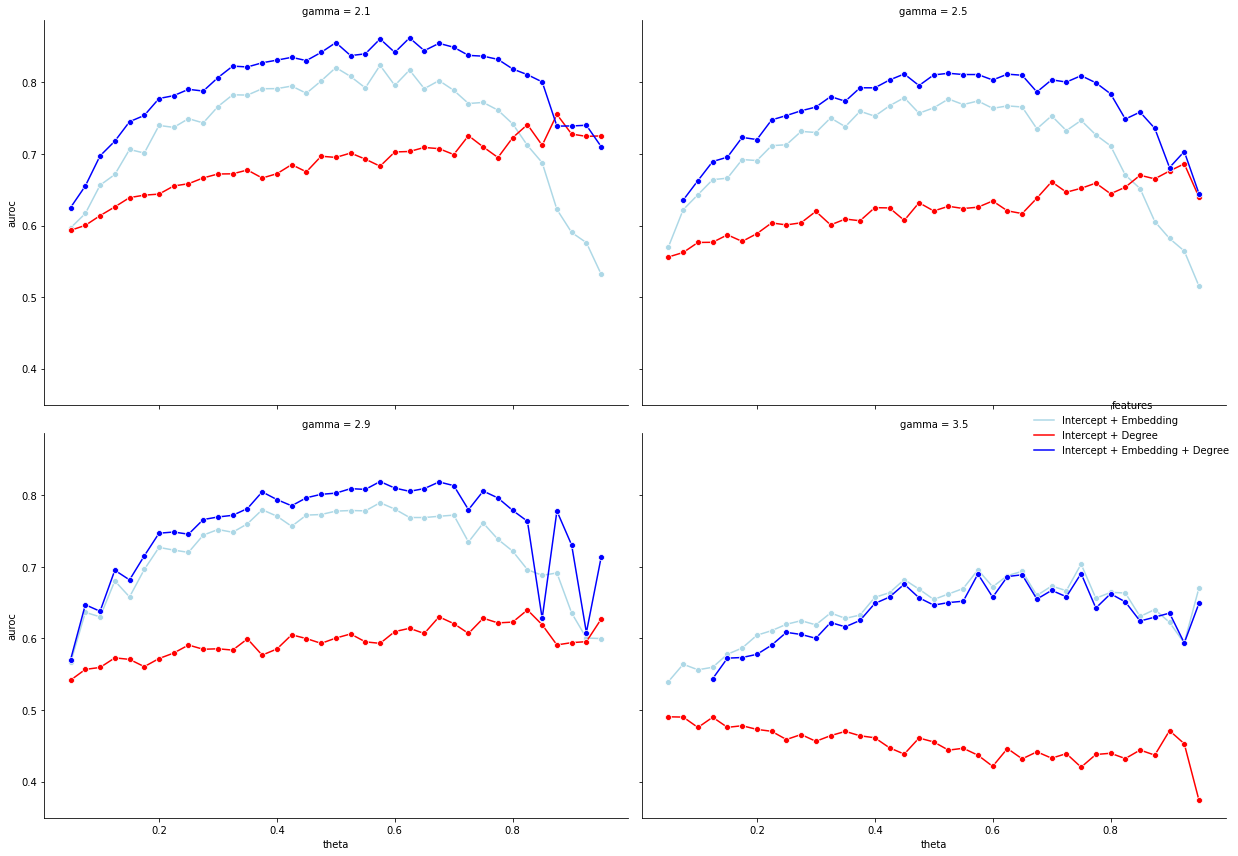

In [9]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.relplot(
    data=df_, kind="line",
    x="theta", y="auroc",
    hue="features", palette=PALETTE,
    col="gamma", col_wrap=2,
    marker="o",
    height=6, aspect=1.2,
)

# Axes configuration

# Figure-level attributes

# Save plot
plt.tight_layout()
plt.savefig(
    f"{FIGROOT}/line_auroc-theta_col-gamma_hue-features_{TAG}.png",
    facecolor="white",
    transparent=False
)

<Figure size 432x288 with 0 Axes>

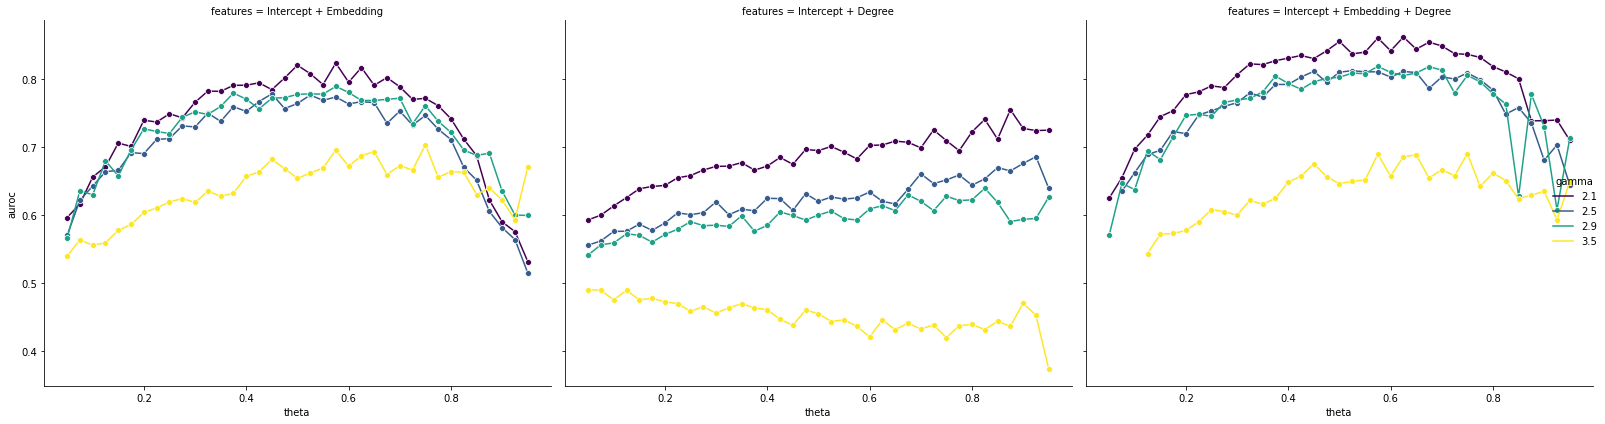

In [10]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.relplot(
    data=df_, kind="line",
    x="theta", y="auroc",
    hue="gamma", palette="viridis",
    col="features",
    marker="o",
    height=6, aspect=1.2,
)

# Axes configuration

# Figure-level attributes

# Save plot
plt.tight_layout()
plt.savefig(
    f"{FIGROOT}/line_auroc-theta_hue-gamma_col-features_{TAG}.png",
    facecolor="white",
    transparent=False
)

### Case Studies

#### Easy

<Figure size 432x288 with 0 Axes>

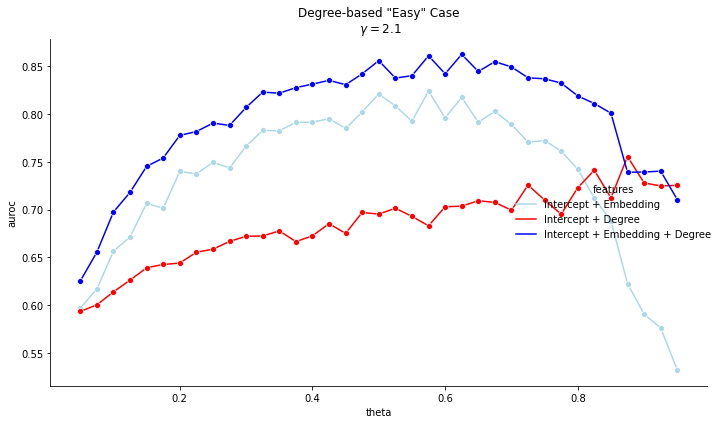

In [11]:
# Instantiate figure, subset relevant data
case_easy_gamma = 2.1  # strong degree heterogeneity
case_easy = df_.query("gamma == @case_easy_gamma")
plt.figure()

# Plotting data
sns.relplot(
    data=case_easy, kind="line",
    x="theta", y="auroc",
    hue="features", palette=PALETTE,
    marker="o",
    height=6, aspect=1.2,
)

# Axes configuration

# Figure-level attributes
plt.title(f"Degree-based \"Easy\" Case\n $\\gamma = ${case_easy_gamma}")

# Save plot
plt.tight_layout()

#### Hard

<Figure size 432x288 with 0 Axes>

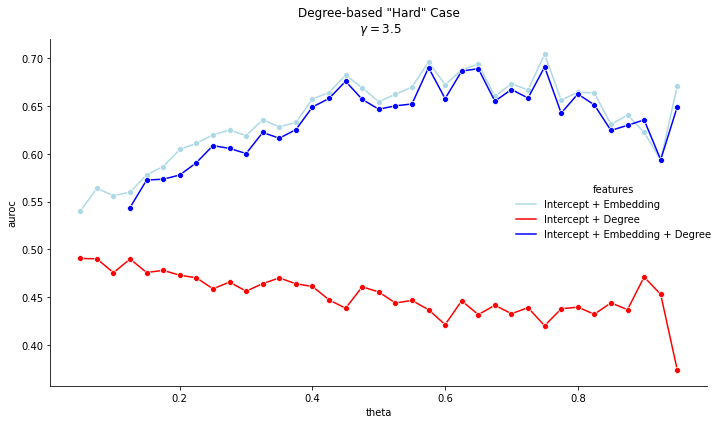

In [12]:
# Instantiate figure, subset relevant data
case_hard_gamma = 3.5  # strong degree heterogeneity
case_hard = df_.query("gamma == @case_hard_gamma")
plt.figure()

# Plotting data
sns.relplot(
    data=case_hard, kind="line",
    x="theta", y="auroc",
    hue="features", palette=PALETTE,
    marker="o",
    height=6, aspect=1.2,
)

# Axes configuration

# Figure-level attributes
plt.title(f"Degree-based \"Hard\" Case\n $\\gamma = ${case_hard_gamma}")

# Save plot
plt.tight_layout()

#### Extremum comparison

<Figure size 432x288 with 0 Axes>

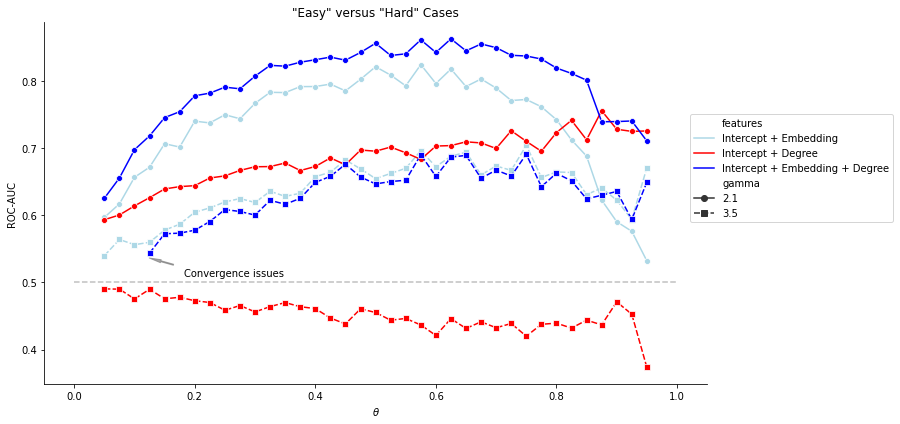

In [13]:
# Instantiate figure, subset relevant data
case_compare_gamma = [2.1, 3.5]  # strong degree heterogeneity
case_compare = df_.query("gamma in @case_compare_gamma")
plt.figure()

# Plotting data
ax = sns.relplot(
    data=case_compare, kind="line",
    x="theta", y="auroc",
    hue="features", palette=PALETTE,
    style="gamma",
    markers=["o", "s"],
    height=6, aspect=1.2,
)
plt.hlines(0.5, 0, 1, linestyle="--", color="gray", alpha=0.5)

# Axes configuration
plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")


# Figure-level attributes
sns.move_legend(ax, "center right", bbox_to_anchor=(1.25,0.6), ncol=1, frameon=True)
plt.title(f"\"Easy\" versus \"Hard\" Cases")
plt.annotate(
    "Convergence issues",
    xy=(0.11, 0.54), xytext=(0.1825, 0.51),
    arrowprops={
        "shrink": 0.2,
        "width": 1,
        "headwidth": 3,
        "alpha": 0.7,
        "color": "gray"
    }
)

# Save plot
plt.tight_layout()

## Comparison with prior results

In [14]:
def community_finder (G):
    # >>> Book-keeping >>>
    sigma = {}
    c = 0

    # <<< Book-keeping <<<

    # >>> Community detection >>>
    # Apply community detection to network
    C = algorithms.louvain(G)

    # Form node -> community_id mapping
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1

    # Estimate community strength
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
    # <<< Community detection <<<

    return sigma, mu, tot

In [15]:
def classifier (rem_G1, rem_G2, Etest, TT = 1, show_log = False):
     # >>> DC Classifier >>>
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)


        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)

        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)

            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            if show_log == True:
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< DC Classifier <<<

    # >>> D Classifier >>>
    if TT == 1:
        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            s2 = rem_G2.degree(n)*rem_G2.degree(m)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< D Classifier <<<

In [16]:
def perform_analysis (G1, G2, step, TT = 0):

    # >>> Book-keeping >>>
    x , y, z  = [], [], []
    frac = 0.0
    # <<< Book-keeping <<<

    # >>> Sweep over relative size of training set >>>
    while frac < 1.0:
        if frac <= 1.0 - step:
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))

            # Observe information
            rem_G1, rem_G2, Etest, Etrain  = partial_information (G1, G2, frac)

            # Reconstruct multiplex
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)

            # Measure reconstruction performance
            acc = accuracy_score(ground_truth, classification)
            auc = roc_auc_score(ground_truth, scores)

            x.append(frac)
            y.append(acc)
            z.append(auc)

        frac += step
    # <<< Sweep over relative size of training set <<<

    results = [x, y, z]
    return results

In [26]:
records = []
for theta in np.linspace(0.05, 0.95, num=37, endpoint=True):
    cache = get_preprocessed_data("LFR_mu-0.1_prob-1.0", (1, 2), theta, 1, ROOT = "../../data/input/preprocessed/synthetic")
    G, H = cache.remnants
    fracs, accs, aucs = perform_analysis (G, H, 1.0, TT = 0)

    records.append({
        "theta": theta,
        "auroc": aucs[0],
        "accuracy": accs[0]
    })

df_f2 = pd.DataFrame.from_records(records)

# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00
# 0.00   0.00


### Comparison case studies

<Figure size 432x288 with 0 Axes>

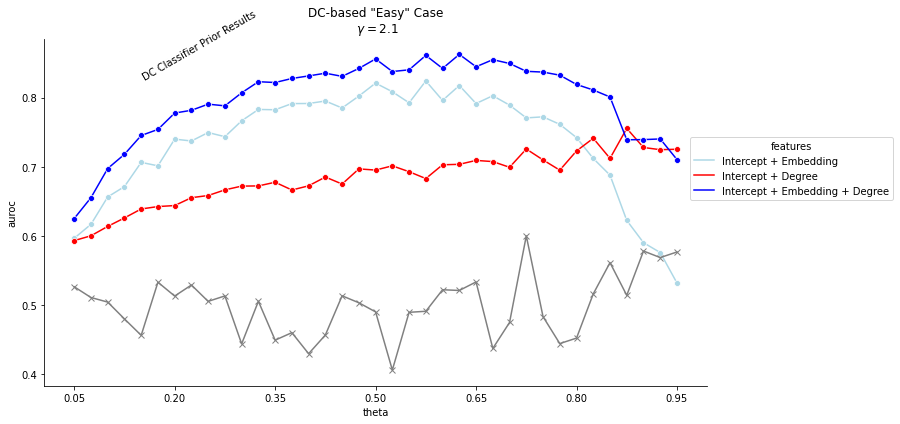

In [23]:
# Instantiate figure, subset relevant data
case_easy_gamma = 2.1  # strong degree heterogeneity
case_easy = df_.query("gamma == @case_easy_gamma")
case_easy_prior = df_f2.query("gamma == @case_easy_gamma")
plt.figure()

# Plotting data
ax = sns.relplot(
    data=case_easy, kind="line",
    x="theta", y="auroc",
    hue="features", palette=PALETTE,
    marker="o",
    height=6, aspect=1.2,
)
plt.plot(case_easy_prior.theta, case_easy_prior.auroc, linestyle="-", color="gray", marker="x")

# Axes configuration
plt.xticks(sorted(set(case_easy.theta))[::6])

# Figure-level attributes
plt.title(f"DC-based \"Easy\" Case\n $\\gamma = ${case_easy_gamma}")
plt.annotate(
    "DC Classifier Prior Results",
    xy=(0.2, 0.85), xytext=(0.15, 0.825),
    rotation=30
)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.25, 0.6), ncol=1, frameon=True)

# Save plot
plt.tight_layout()
plt.savefig(
    f"{FIGROOT}/line_auroc-theta_hue-features_gamma-2.1_compare-DC_{TAG}.png",
    facecolor="white",
    transparent=False
)

<Figure size 432x288 with 0 Axes>

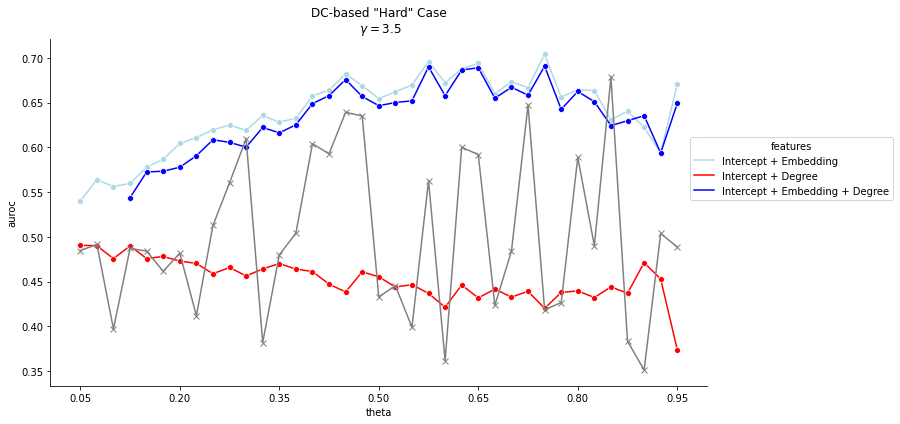

In [25]:
# Instantiate figure, subset relevant data
case_easy_gamma = 3.5  # strong degree heterogeneity
case_easy = df_.query("gamma == @case_easy_gamma")
case_easy_prior = df_f2.query("gamma == @case_easy_gamma")
plt.figure()

# Plotting data
ax = sns.relplot(
    data=case_easy, kind="line",
    x="theta", y="auroc",
    hue="features", palette=PALETTE,
    marker="o",
    height=6, aspect=1.2,
)
plt.plot(case_easy_prior.theta, case_easy_prior.auroc, linestyle="-", color="gray", marker="x")
# plt.hlines(0.5, 0, 1, linestyle="--", color="gray", alpha = 0.5)


# Axes configuration
plt.xticks(sorted(set(case_easy.theta))[::6])

# Figure-level attributes
plt.title(f"DC-based \"Hard\" Case\n $\\gamma = ${case_easy_gamma}")
plt.annotate(
    "DC Classifier Prior Results",
    xy=(0.2, 0.85), xytext=(0.55, 0.785),
    rotation=25
)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.25,0.6), ncol=1, frameon=True)

# Save plot
plt.tight_layout()
plt.savefig(
    f"{FIGROOT}/line_auroc-theta_hue-features_gamma-3.5_compare-DC_{TAG}.png",
    facecolor="white",
    transparent=False
)

### Amalgamated comparisons

<Figure size 640x480 with 0 Axes>

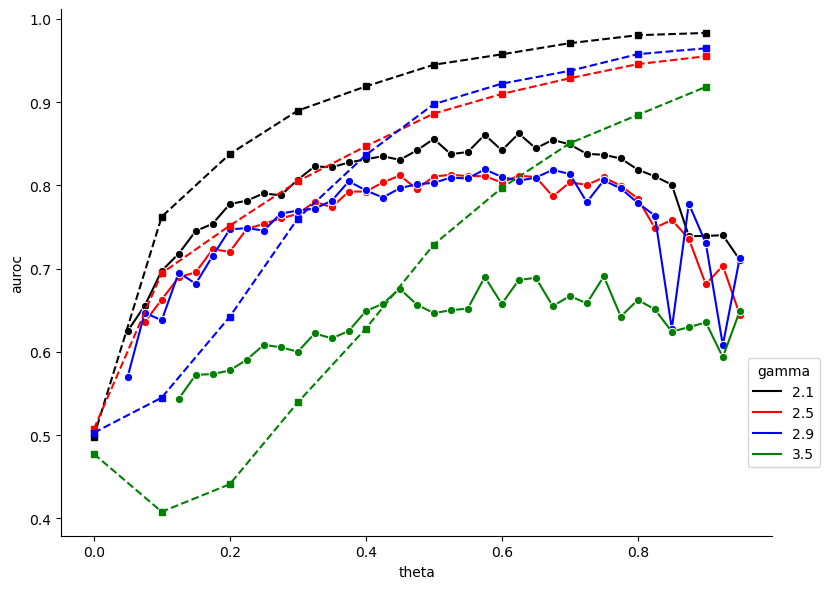

In [ ]:
# Instantiate figure, subset relevant data
df__ = df.query("features == 'Intercept + Embedding + Degree'")
prior_ = df_f2.query("mu == 0.1")
plt.figure()

COLORS = ["black", "red", "blue", "green"]

# Plotting data
ax = sns.relplot(
    data=df__, kind="line",
    x="theta", y="auroc",
    hue="gamma", palette=COLORS,
    marker="o",
    height=6, aspect=1.2,
)

_c = 0
for gamma, data_ in prior_.groupby("gamma"):
    plt.plot(
        data_.pfi[:10], data_.AUROC[:10],
        label=gamma, color=COLORS[_c],
        marker="s", linestyle="--",
        markersize=4
    )
    _c += 1

# Axes configuration
# plt.xticks(sorted(set(case_easy.theta))[::6])

# Figure-level attributes


sns.move_legend(ax, "lower right", bbox_to_anchor=(1.05,0.2), frameon=True)

# Save plot
plt.tight_layout()

## Singular measures

<Figure size 640x480 with 0 Axes>

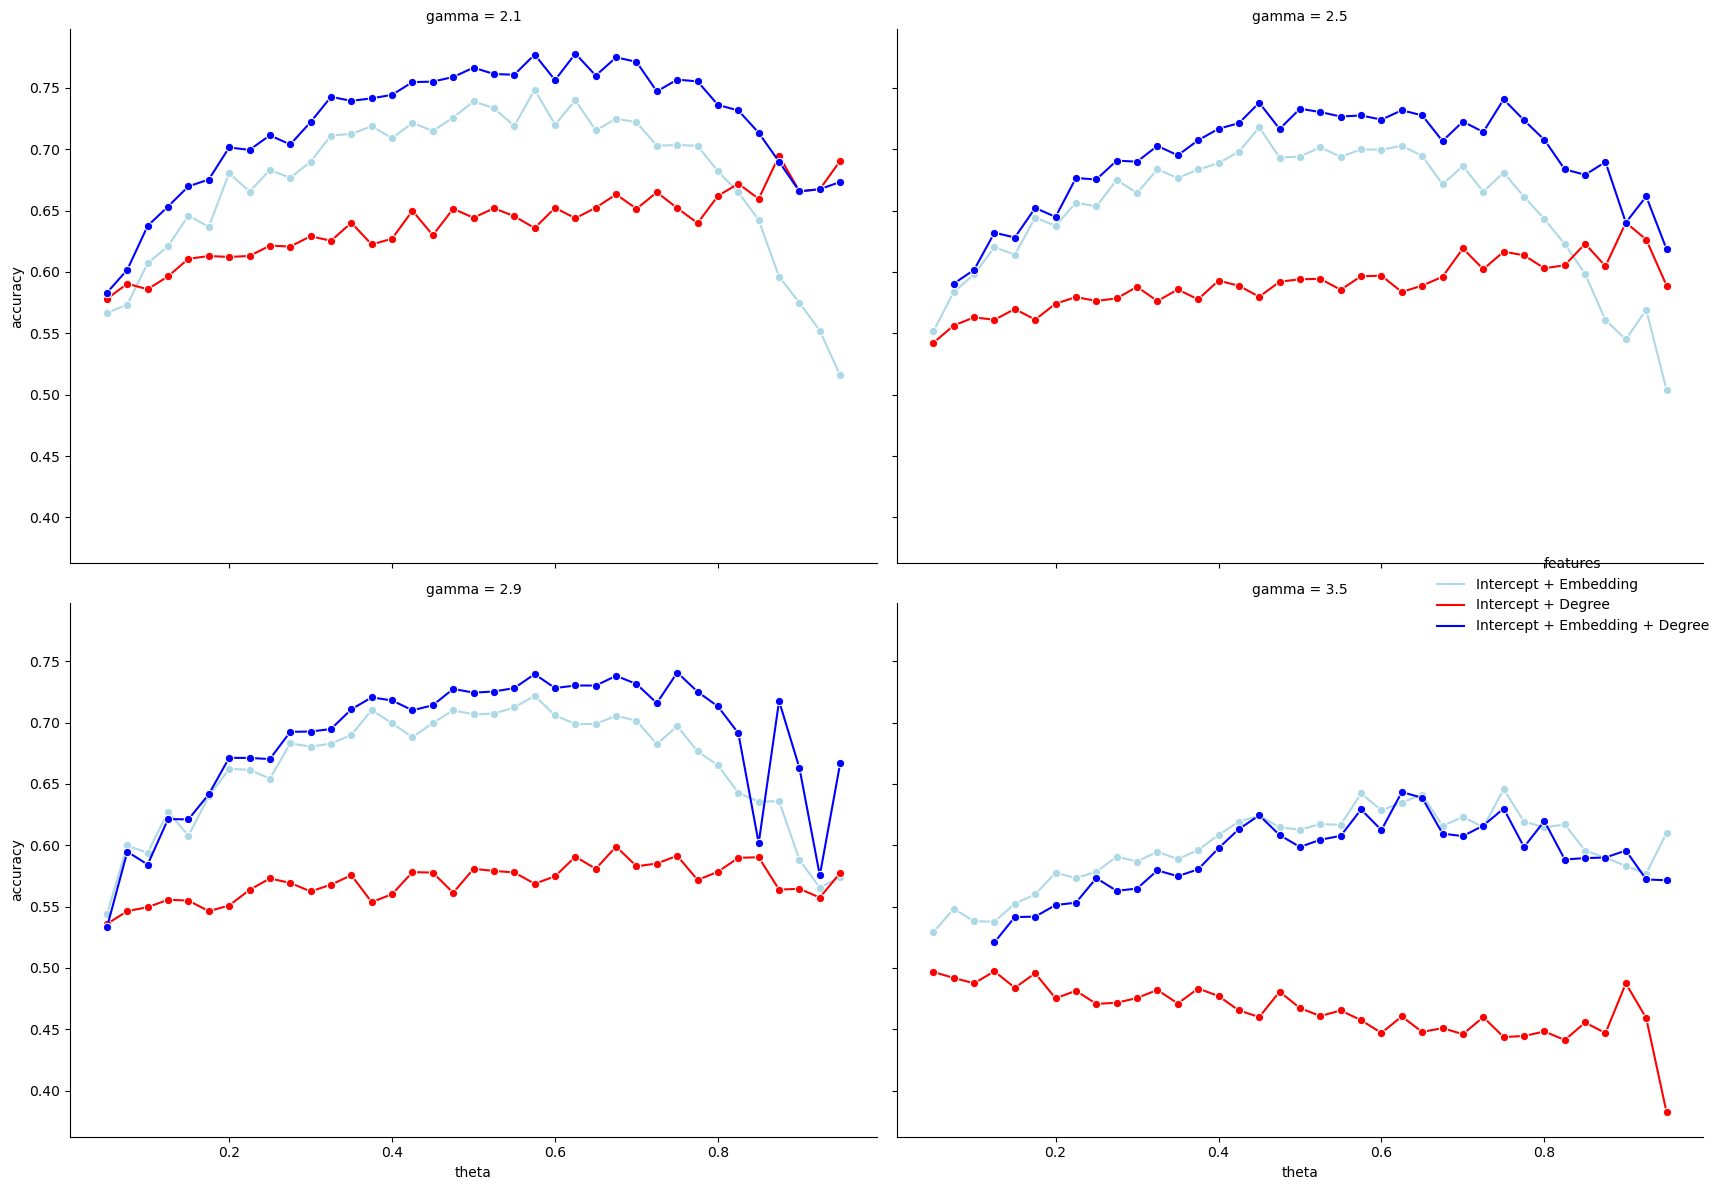

In [ ]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.relplot(
    data=df_, kind="line",
    x="theta", y="accuracy",
    hue="features", palette=PALETTE,
    col="gamma", col_wrap=2,
    marker="o",
    height=6, aspect=1.2,
)

# Axes configuration

# Figure-level attributes

# Save plot
plt.tight_layout()

# Coefficient analysis

## Preprocessing

In [ ]:
gamma = 2.1
df_ = df.query("features in @_features")
df_ = df_.query("gamma == @gamma")

df_melted = df_.melt(
    id_vars=["theta", "features"],
    value_vars=["intercept", "coef_emb", "coef_deg"],
)
df_melted["absvalue"] = df_melted["value"].apply(np.abs)

## Coefficient evolution

<Figure size 640x480 with 0 Axes>

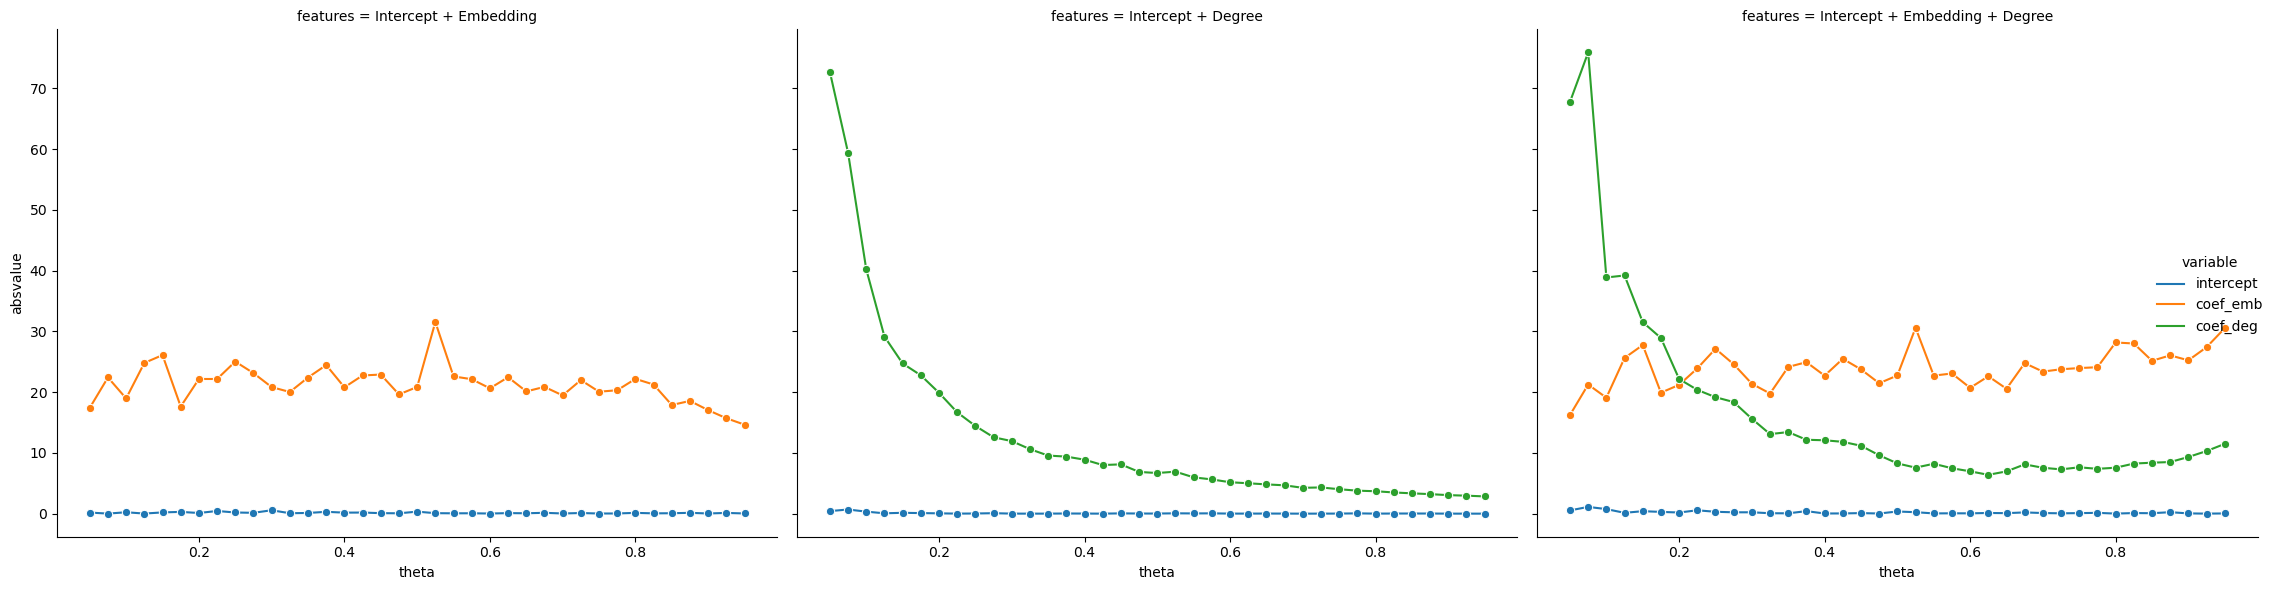

In [ ]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.relplot(
    data=df_melted, kind="line",
    x="theta", y="absvalue",
    hue="variable",
    col="features",
    marker="o",
    height=6, aspect=1.2,
)

# Axes configuration

# Figure-level attributes

# Save plot
plt.tight_layout()
plt.savefig(
    f"{FIGROOT}/line_abscoefs-theta_hue-feature_col-features_gamma-2.1_{TAG}.png",
    facecolor="white",
    transparent=False
)

<Figure size 640x480 with 0 Axes>

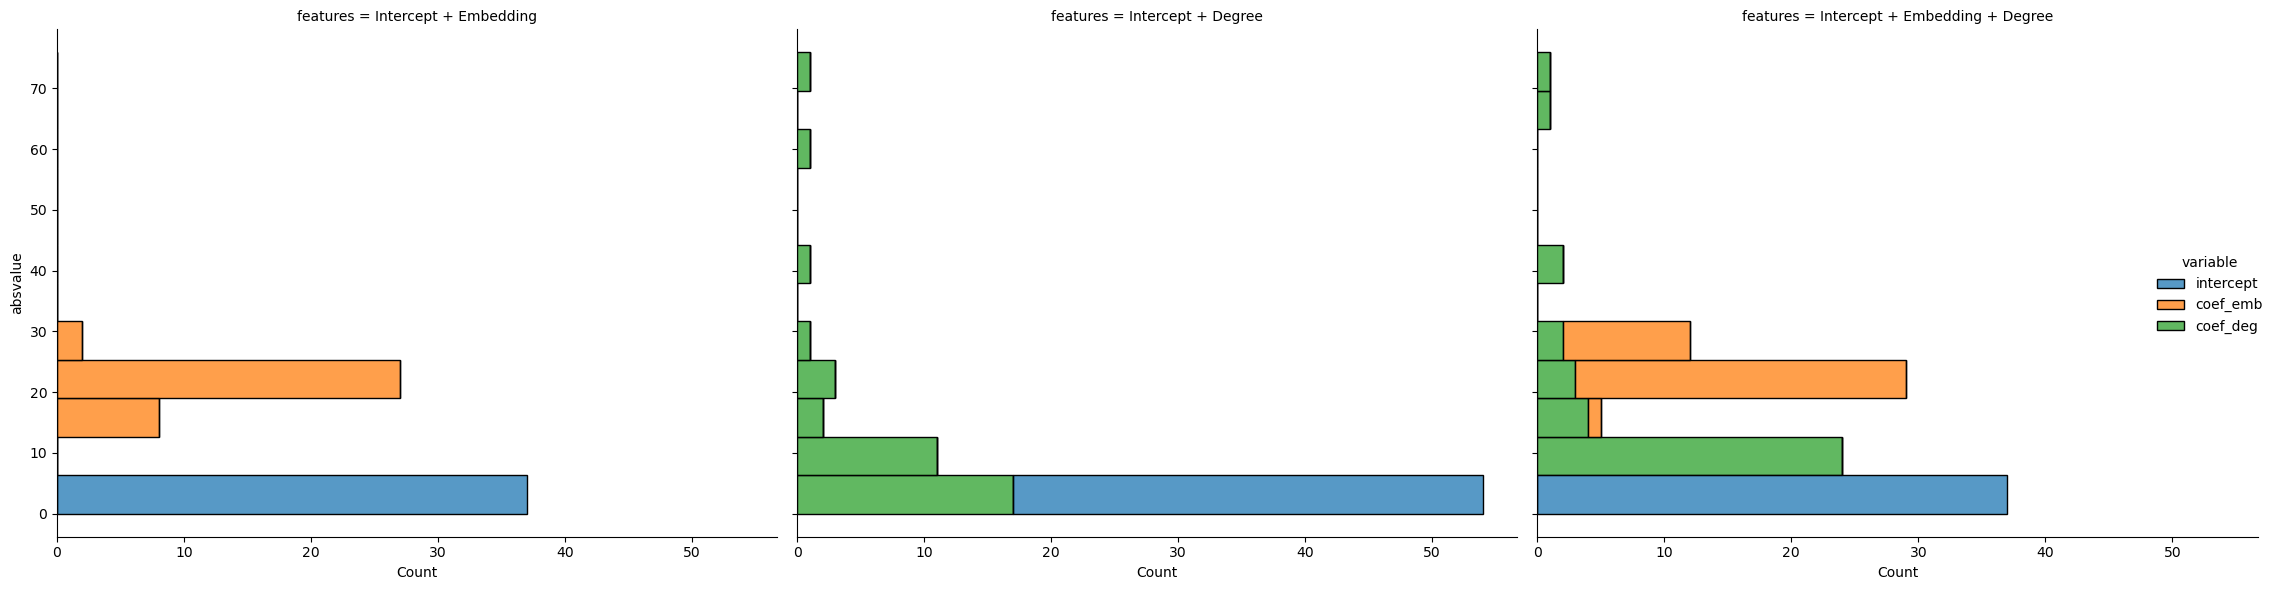

In [ ]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df_melted, kind="hist",
    y="absvalue",
    hue="variable",
    col="features",
    height=6, aspect=1.2,
    multiple="stack"
)

# Axes configuration

# Figure-level attributes

# Save plot
plt.tight_layout()

# Decision boundaries

In [ ]:
def logistic(emb=0, deg=0, intercept=0, coef_emb=0, coef_deg=0):
    a = intercept + coef_emb*emb + coef_deg*deg
    b = 1 / (1 + np.exp(-a))

    return b

In [ ]:
gamma = 2.1

Text(0.5, 1.0, '$\\gamma=$2.1 Decision Boundary\nIntercept + Embedding features')

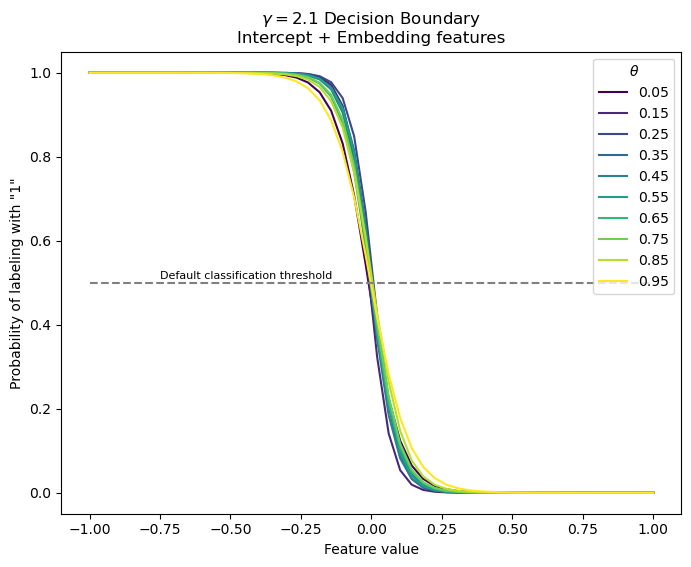

In [ ]:
# Subset data
df_ = df.query("features == 'Intercept + Embedding' & gamma == @gamma")

# Set up predictor
deg = coef_deg = 0
X = np.linspace(-1,1)

# Set up figure
plt.figure(figsize=(8,6))
viridis = mpl.colormaps["viridis"]
idx = 0  # colormap index
theta_skip = 4  # so our legend isnt huge

# Plot predictors
for theta, df_group in list(df_.groupby("theta"))[::theta_skip]:
    # Calculate decision boundary
    intercept = df_group.iloc[0].intercept
    coef_emb = float(df_group.iloc[0].coefficients[1:-1])
    Y = [
        logistic(emb=x, deg=deg, intercept=intercept, coef_emb=coef_emb, coef_deg=coef_deg)
        for x in X
    ]

    # Plot logistic curve
    plt.plot(X, Y, label=f"{theta:.2f}", color=viridis(idx/9))

    # Increment colormap
    idx += 1

plt.hlines(0.5, -1, 1, linestyles="dashed", color="gray")
plt.legend(title="$\\theta$")

# Prettify figure
plt.annotate(
    "Default classification threshold",
    xy=(-0.5, 0.5), xytext=(-0.75, 0.51),
    size="8"
)
plt.xlabel("Feature value")
plt.ylabel("Probability of labeling with \"1\"")

plt.title(f"$\\gamma=${gamma} Decision Boundary\nIntercept + Embedding features")

Text(0.5, 1.0, '$\\gamma = $2.1 Decision Boundary\nIntercept + Degree features')

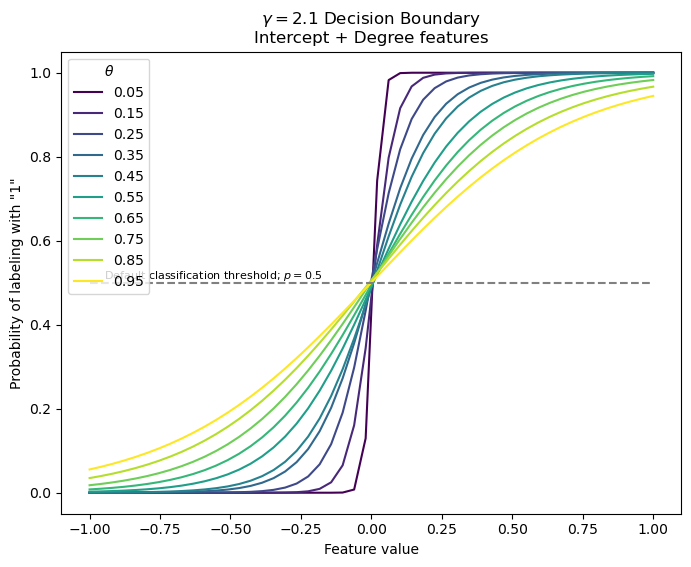

In [ ]:
# Subset data
df_ = df.query("features == 'Intercept + Degree' & gamma == @gamma")

# Set up predictor
emb = coef_emb = 0
X = np.linspace(-1,1)

# Set up figure
plt.figure(figsize=(8,6))
viridis = mpl.colormaps["viridis"]
idx = 0  # colormap index
theta_skip = 4  # so our legend isnt huge

# Plot predictors
for theta, df_group in list(df_.groupby("theta"))[::theta_skip]:
    # Calculate decision boundary
    intercept = df_group.iloc[0].intercept
    coef_deg = float(df_group.iloc[0].coefficients[1:-1])
    Y = [
        logistic(emb=emb, deg=x, intercept=intercept, coef_emb=coef_emb, coef_deg=coef_deg)
        for x in X
    ]

    # Plot logistic curve
    plt.plot(X, Y, label=f"{theta:.2f}", color=viridis(idx/9))

    # Increment colormap
    idx += 1

plt.hlines(0.5, -1, 1, linestyles="dashed", color="gray")
plt.legend(title="$\\theta$")

# Prettify figure
plt.annotate(
    "Default classification threshold; $p=0.5$",
    xy=(-0.5, 0.5), xytext=(-0.95, 0.51),
    size="8"
)
plt.xlabel("Feature value")
plt.ylabel("Probability of labeling with \"1\"")

plt.title(f"$\\gamma = ${gamma} Decision Boundary\nIntercept + Degree features")

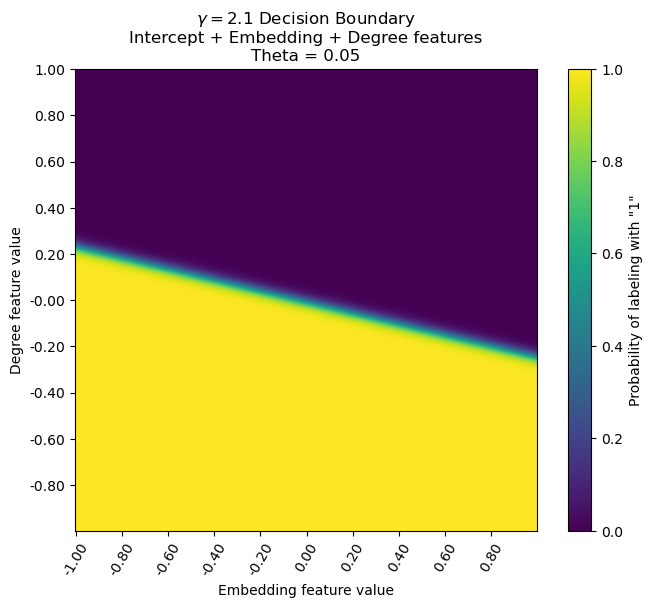

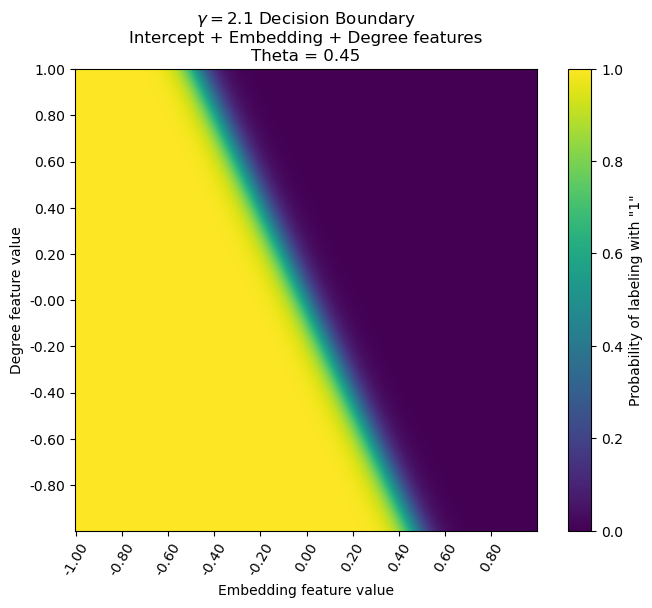

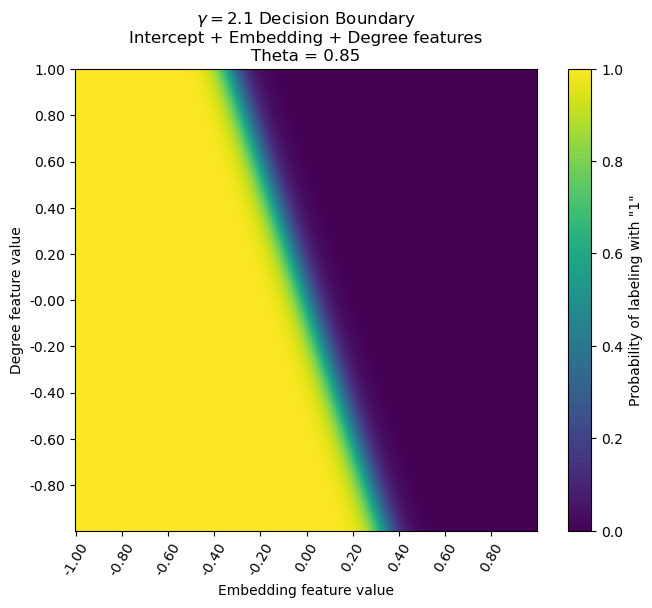

In [ ]:
# Subset data
df_ = df.query("features == 'Intercept + Embedding + Degree' & gamma == @gamma")

# Set up predictor
X = np.linspace(-1,1, num=500)

# Set up figure

# Calculate decision boundary
for df_group in list(df_.groupby("theta"))[::16]:
    plt.figure(figsize=(8,6))
    theta, df_group = df_group
    intercept = df_group.iloc[0].intercept
    if intercept != intercept:
        continue
    coefs = df_group.iloc[0].coefficients[1:-1].split(", ")
    coef_emb = float(coefs[0])
    coef_deg = float(coefs[1])

    Z = np.array([
        logistic(emb=x, deg=y, intercept=intercept, coef_emb=coef_emb, coef_deg=coef_deg)
        for y in X for x in X
    ]).reshape(len(X), len(X))

    # Plot logistic curve
    plt.imshow(Z)

    # Prettify figure
    plt.colorbar(label="Probability of labeling with \"1\"")

    plt.xticks(range(len(X))[::50], labels=[f"{x:.2f}" for x in X[::50]], rotation=60)
    plt.yticks(range(len(X))[::50], labels=[f"{x:.2f}" for x in X[::-50]])

    plt.xlabel("Embedding feature value")
    plt.ylabel("Degree feature value")
    plt.title(f"$\\gamma = ${gamma} Decision Boundary\nIntercept + Embedding + Degree features\nTheta = {theta:.2f}")